In [1]:
import pickle
import tarfile
from random import choices
from itertools import product, cycle
import numpy as np
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

# Downloading the dataset

In [2]:
def unpickle(file):
    """
    source: https://www.cs.toronto.edu/~kriz/cifar.html
    """
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data

In [3]:
dataset = requests.get('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz')

with open('cifar-10-python.tar.gz', 'wb') as dataset_file:
    dataset_file.write(dataset.content)

In [4]:
with tarfile.open('cifar-10-python.tar.gz') as tar:
    tar.extractall()

# "Training" the model or preprocessing the dataset

In [5]:
def process_image(data: np.ndarray) -> np.ndarray:
    """
    
    takes image as a row of 3072 elements, 
    where the first 1024 entries contain the red channel values,
    the next 1024 the green, and the final 1024 the blue.
    
    returns image as an array of shape (32, 32, 3)
    
    """
    red_channel, green_channel, blue_channel = np.split(data, 3)
    pixels = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    return np.reshape(pixels, (32, 32, 3))

In [6]:
def process_batch(batch: np.ndarray) -> tuple[list[np.ndarray], list[int]]:
    """
    
    processes a batch and returns a tuple of a list of processed images with shape (32, 32, 3) and list of labels
    
    """
    batch_images = list(map(process_image, batch[b'data']))
    batch_labels = batch[b'labels']
    
    return batch_images, batch_labels

In [7]:
batch_filenames = ['cifar-10-batches-py/data_batch_1',
                   'cifar-10-batches-py/data_batch_2',
                   'cifar-10-batches-py/data_batch_3', 
                   'cifar-10-batches-py/data_batch_4',
                   'cifar-10-batches-py/data_batch_5']

train_images, train_labels = [], []
for filename in batch_filenames:
    current_batch = unpickle(filename)
    images, labels = process_batch(current_batch)
    train_images.extend(images)
    train_labels.extend(labels)

In [8]:
test_batch = unpickle('cifar-10-batches-py/test_batch')
test_images, test_labels = process_batch(test_batch)

In [9]:
meta_data = unpickle('cifar-10-batches-py/batches.meta')
label_names = list(map(bytes.decode, meta_data[b'label_names']))

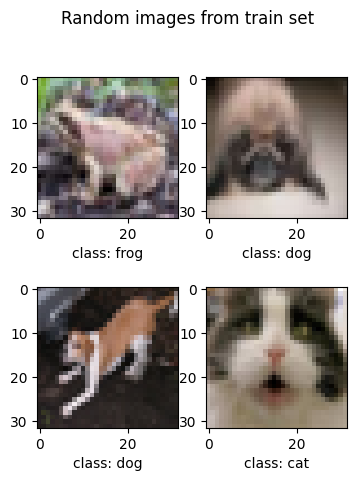

In [10]:
indices = choices(range(len(train_images)), k=4)

figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(4, 5))
for i, j in product(range(2), range(2)):
    axes[i, j].imshow(train_images[indices[i + 2 * j]])
    axes[i, j].set_xlabel(f'class: {label_names[train_labels[indices[i + 2 * j]]]}')
    figure.suptitle('Random images from train set')

plt.show()

In [11]:
def distance(first_image: np.ndarray, second_image: np.ndarray) -> int:
    return np.sum(np.abs(first_image - second_image))

In [12]:
def predict(image: np.ndarray) -> int:
    """
    
    Checks distances between given image and images from train set and returns a label of the closest one
    
    """
    distances = list(map(distance, train_images, cycle([image])))
    return train_labels[np.argmin(distances)]

In [13]:
def evaluate(): 
    predicted_labels = [predict(image) for image in tqdm(test_images)]
    correct_count = 0
    for test_label, predicted_label in zip(test_labels, predicted_labels):
        if test_label == predicted_label:
            correct_count += 1
    
    print(f'Predicted correctly: {correct_count}/{len(test_images)}, accuracy: {correct_count / len(test_images)}')

In [14]:
evaluate()

100%|██████████| 10000/10000 [1:26:19<00:00,  1.93it/s]

Predicted correctly: 2492/10000, accuracy: 0.2492
